In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.special import digamma, gammaln
import scipy

In [2]:
x_1 = pd.read_csv("./data_csv/X_set1.csv", header = None).values
x_2 = pd.read_csv("./data_csv/X_set2.csv", header = None).values
x_3 = pd.read_csv("./data_csv/X_set3.csv", header = None).values

y_1 = pd.read_csv("./data_csv/y_set1.csv", header = None).values
y_2 = pd.read_csv("./data_csv/y_set2.csv", header = None).values
y_3 = pd.read_csv("./data_csv/y_set3.csv", header = None).values

z_1 = pd.read_csv("./data_csv/z_set1.csv", header = None).values
z_2 = pd.read_csv("./data_csv/z_set2.csv", header = None).values
z_3 = pd.read_csv("./data_csv/z_set3.csv", header = None).values

In [3]:
print(x_1.shape, x_2.shape, x_3.shape, y_1.shape, y_2.shape, y_3.shape, z_1.shape, z_2.shape, z_3.shape)

(100, 101) (250, 251) (500, 501) (100, 1) (250, 1) (500, 1) (100, 1) (250, 1) (500, 1)


In [4]:
def update_q_lambda(e_0, f_0, N, Y_T_Y, Y_T_X, mu_t, sigma_t, X):
    e_new = float(e_0 + 0.5*N)
    c1 = sigma_t + np.dot(mu_t, mu_t.T)
    c2 = np.dot(X, np.dot(c1, X.T))
    c3 = Y_T_Y - 2*np.dot(Y_T_X, mu_t) + np.trace(c2)
    f_new = float(f_0 + 0.5*c3)
    return e_new, f_new

In [5]:
def update_q_alphak(a_0, b_0, mu_t_k, sigma_t_kk):
    a_new_k = float(a_0 + 0.5)
    b_new_k = float(b_0 + 0.5*(mu_t_k**2 + sigma_t_kk))
    return a_new_k, b_new_k

In [6]:
def update_q_w(a_t, b_t, e_t, f_t, X_T_Y, X_T_X):
    E_alpha = a_t/b_t
    E_lambda = e_t/float(f_t)
    c1 = E_lambda*X_T_X
    c2 = np.diag(E_alpha) + c1
    sigma_t = np.linalg.inv(c2)
    c3 = E_lambda*X_T_Y
    mu_t = np.dot(sigma_t, c3)
    return mu_t, sigma_t

In [7]:
def ln_q_lambda(e_t, f_t):
    c1 = math.log(f_t)
    c2 = gammaln(e_t)
    c3 = (e_t - 1)*digamma(e_t)
    c = c1 - c2 + c3 - e_t
    return c

In [8]:
def ln_q_alpha(a_t, b_t):
    c = 0
    for k in range(len(a_t)):
        c1 = math.log(b_t[k])
        c2 = gammaln(a_t[k])
        c3 = (a_t[k] - 1)*digamma(a_t[k])
        c4 = c1 - c2 + c3 - a_t[k]
        c += c4
    return c

In [9]:
def ln_q_w(sigma_t):
    sign, c1 = np.linalg.slogdet(sigma_t)
    c = -0.5*(sign * c1)
    return c

In [10]:
def ln_p_lambda(e_0, f_0, e_t, f_t):
    c1 = e_0*math.log(f_0)
    c2 = gammaln(e_0)
    c3 = (e_0 - 1)*(digamma(e_t) - math.log(f_t))
    c4 = f_0*(e_t/float(f_t))
    c = c1 - c2 + c3 -c4
    return c

In [11]:
def ln_p_alpha(a_0, b_0, a_t, b_t):
    c = 0
    for k in range(len(a_t)):
        c1 = a_0*math.log(b_0)
        c2 = gammaln(a_0)
        c3 = (a_0 - 1)*(digamma(a_t[k]) - math.log(b_t[k]))
        c4 = b_0*(a_t[k]/float(b_t[k]))
        c5 = c1 - c2 + c3 - c4
        c += c5
    return c

In [12]:
def ln_p_w(a_t, b_t, mu_t, sigma_t):
    c = 0
    for k in range(len(a_t)):
        c1 = digamma(a_t[k]) - math.log(b_t[k])
        c2 = mu_t[k]**2 + sigma_t[k][k]
        c3 = a_t[k]/float(b_t[k])
        c4 = math.log(2*math.pi)
        c5 = c1 - (c2*c3) - c4
        c+= c5
    return (0.5*c)

In [13]:
def ln_p_y(N, e_t, f_t, mu_t, sigma_t, Y_T_Y, Y_T_X, X_T_X, X):
    c1 = sigma_t + np.dot(mu_t, mu_t.T)
    c2 = np.dot(X, np.dot(c1, X.T))
    c3 = Y_T_Y - 2*np.dot(Y_T_X, mu_t) + np.trace(c2)
    c4 = (e_t/float(2*f_t))*c3
    c5 = (float(N)/2)*(digamma(e_t) - math.log(f_t) - math.log(2*math.pi))
    c = c5 - c4
    return c

In [14]:
def variational_inference(X, Y, a_0, b_0, e_0, f_0):
    N = X.shape[0]
    d = X.shape[1]
    
    # initialize variables
    e_t = e_0
    f_t = f_0
    a_t = np.array([a_0] * d, dtype='float64')
    b_t = np.array([b_0] * d, dtype='float64')
    
    # mu is matrix of zeros and sigma is identity matrix initially
    mu_t = np.zeros(d, dtype='float64')
    sigma_t = np.identity(d, dtype='float64')
    
    Y_T_Y = np.dot(Y.T, Y)[0][0]
    Y_T_X = np.dot(Y.T, X)
    X_T_Y = np.dot(X.T, Y)
    X_T_X = np.dot(X.T, X)
    
    objective_function = []
    
    for t in range(500):
        e_t, f_t = update_q_lambda(e_0, f_0, N, Y_T_Y, Y_T_X, mu_t, sigma_t, X)
        
        for k in range(d):
            a_t[k], b_t[k] = update_q_alphak(a_0, b_0, mu_t[k], sigma_t[k][k])

        mu_t, sigma_t = update_q_w(a_t, b_t, e_t, f_t, X_T_Y, X_T_X)
        
        c1 = ln_p_w(a_t, b_t, mu_t, sigma_t)
        c2 = ln_p_lambda(e_0, f_0, e_t, f_t)
        c3 = ln_p_alpha(a_0, b_0, a_t, b_t)
        c4 = ln_p_y(N, e_t, f_t, mu_t, sigma_t, Y_T_Y, Y_T_X, X_T_X, X)
        c5 = ln_q_w(sigma_t)
        c6 = ln_q_lambda(e_t, f_t)
        c7 = ln_q_alpha(a_t, b_t)
        
        c = c1 + c2 + c3 + c4 - c5 - c6 - c7
        objective_function.append(c[0][0])
    
    return objective_function, e_t, f_t, a_t, b_t, mu_t, sigma_t

In [15]:
a_0 = b_0 = 1e-16
e_0 = f_0 = 1
obj_fun_1, e_1, f_1, a_1, b_1, mu_1, sigma_1 = variational_inference(x_1, y_1, a_0, b_0, e_0, f_0)

In [16]:
a_0 = b_0 = 1e-16
e_0 = f_0 = 1
obj_fun_2, e_2, f_2, a_2, b_2, mu_2, sigma_2 = variational_inference(x_2, y_2, a_0, b_0, e_0, f_0)

In [17]:
a_0 = b_0 = 1e-16
e_0 = f_0 = 1
obj_fun_3, e_3, f_3, a_3, b_3, mu_3, sigma_3 = variational_inference(x_3, y_3, a_0, b_0, e_0, f_0)

### Question 2. a.

Note that I included all the constants in the calculation of the objective function.

Text(0.5,1,'Dataset 1')

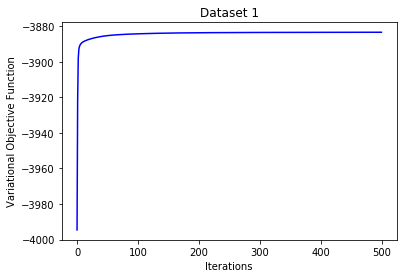

In [18]:
plt.plot(range(500), obj_fun_1, 'b')
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Dataset 1')

Text(0.5,1,'Dataset 2')

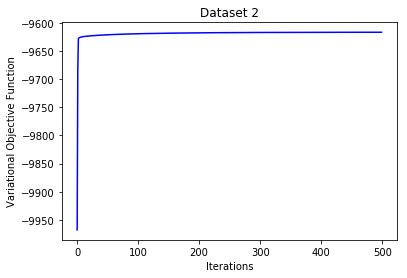

In [19]:
plt.plot(range(500), obj_fun_2, 'b')
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Dataset 2')

Text(0.5,1,'Dataset 3')

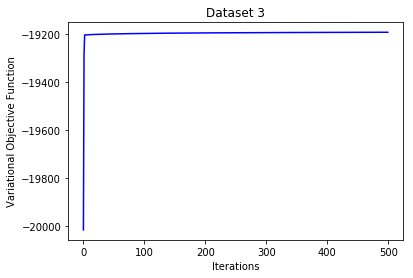

In [20]:
plt.plot(range(500), obj_fun_3, 'b')
plt.xlabel('Iterations')
plt.ylabel('Variational Objective Function')
plt.title('Dataset 3')

### Question 2. b.

Text(0.5,1,'Dataset 1')

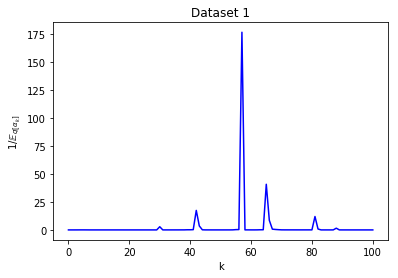

In [21]:
plt.plot(range(x_1.shape[1]), b_1/a_1, 'b')
plt.xlabel('k')
plt.ylabel(r'$1/\mathbb{E}_{q[\alpha_k]}$')
plt.title('Dataset 1')

Text(0.5,1,'Dataset 2')

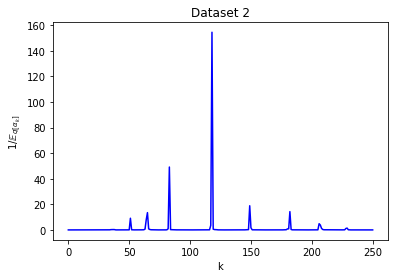

In [22]:
plt.plot(range(x_2.shape[1]), b_2/a_2, 'b')
plt.xlabel('k')
plt.ylabel(r'$1/\mathbb{E}_{q[\alpha_k]}$')
plt.title('Dataset 2')

Text(0.5,1,'Dataset 3')

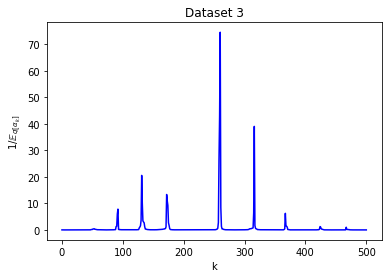

In [23]:
plt.plot(range(x_3.shape[1]), b_3/a_3, 'b')
plt.xlabel('k')
plt.ylabel(r'$1/\mathbb{E}_{q[\alpha_k]}$')
plt.title('Dataset 3')

### Question 2. c.

The value of $\frac{1}{E_{q}[\lambda]}$ for dataset 1 is: 1.0800299564502513

The value of $\frac{1}{E_{q}[\lambda]}$ for dataset 2 is: 0.899462980078765

The value of $\frac{1}{E_{q}[\lambda]}$ for dataset 3 is: 0.978143591847696

### Question 2. d.

Text(0.5,1,'Dataset 1')

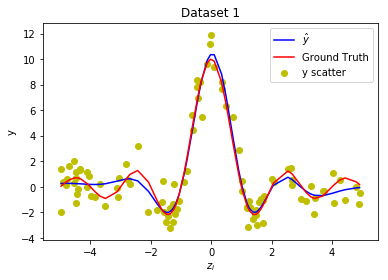

In [27]:
y_hat = np.dot(x_1, mu_1)
plt.plot(z_1, y_hat, 'b', label=r'$\hat{y}$')
plt.scatter(z_1, y_1, c='y', label='y scatter')
plt.plot(z_1, 10 * np.sinc(z_1), c = 'r', label='Ground Truth')
plt.legend()
plt.xlabel(r'$z_{i}$')
plt.ylabel('y')
plt.title('Dataset 1')

Text(0.5,1,'Dataset 2')

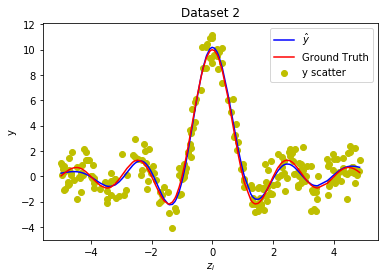

In [29]:
y_hat = np.dot(x_2, mu_2)
plt.plot(z_2, y_hat, 'b', label=r'$\hat{y}$')
plt.scatter(z_2, y_2, c='y', label='y scatter')
plt.plot(z_2, 10 * np.sinc(z_2), c = 'r', label='Ground Truth')
plt.legend()
plt.xlabel(r'$z_{i}$')
plt.ylabel('y')
plt.title('Dataset 2')

Text(0.5,1,'Dataset 3')

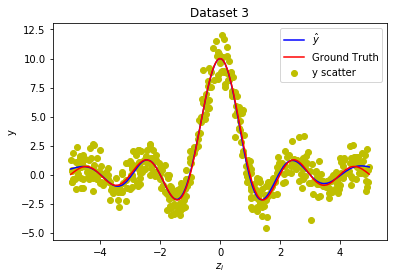

In [28]:
y_hat = np.dot(x_3, mu_3)
plt.plot(z_3, y_hat, 'b', label=r'$\hat{y}$')
plt.scatter(z_3, y_3, c='y', label='y scatter')
plt.plot(z_3, 10 * np.sinc(z_3), c = 'r', label='Ground Truth')
plt.legend()
plt.xlabel(r'$z_{i}$')
plt.ylabel('y')
plt.title('Dataset 3')